<h1 align = 'center'> Neural Networks Demystified </h1>
<h2 align = 'center'> Part 7: Overfitting, Testing, and Regularization </h2>



<h4 align = 'center' > Original author: @stephencwelch </h4>
<h4 align = 'center' > Edited by: Yang Xing </h4>

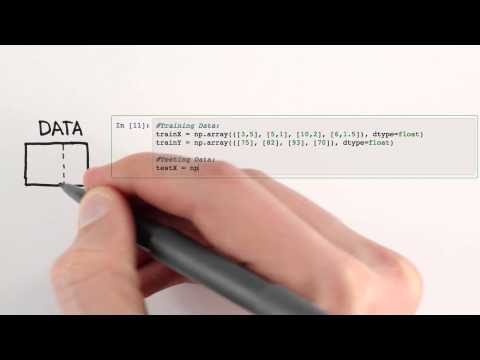

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('S4ZUwgesjS8')

Last time, we trained our Neural Network, and it made suspiciously good predictions of your test score based on how many hours you slept, and how many hours you studied the night before. Before we celebrate and begin changing our sleep and study habits, we need some way to ensure that our model reflects the real world. 

To do this, let’s first spend some time thinking about data. Like a lot of data, our input and output values come from real world observations. The assumption here is that there is some underlying process, and our observations give us insight into the process - BUT our observations are not the same thing as the process, they are just a sample.

Our observation says that when we sleep for 3 hours and study for 5 hours, the grade we earned was a 75. But does this mean that every time you sleep for 3 hours and study for 5 hours you will earn a 75? Of course not, because there are other variables that matter here, such as the difficulty of test, or whether you’ve been paying attention in lectures – we could quantify these variables to build a better model, but even if we did, there would still an element of uncertainty that we could never explicitly model – for example, maybe the test was multiple choice, and you guessed on a few problems. 

One way to think about this problem is that observations are composed of signal and noise. Nate Silver, the guy who correctly predicted the US election results for 50 out of 50 US states in 2012, wrote a great book on exactly this. The idea is that we’re interested in an underlying process, the signal, but in real data, our signal will always be obscured by some level of noise. 

An interesting example of this shows up when comparing the SAT scores of students who take the SAT both Junior and Senior year. Right on the college board’s website it says: “The higher a student's scores as a junior, the more likely that student's subsequent scores will drop”. Why would this be? It seems like students who did well junior year would also do well senior year. We can make sense of this by considering that SAT scores are composed of a signal and a noise component – the signal being the underlying aptitude of the student, and the noise being other factors that effect test scores, basically if the student had a good day or not. Of the students who did well the first time, we expect a disproportionate number to have had a good day – and since having a good day is random, when these students have a regular or bad test day on their next test, their scores will go down. 

So if we can convince our model to fit the signal and not the noise, we should be able to avoid overfitting. First, we’ll work on diagnosing overfitting, then we’ll work on fixing it. Last time we showed our model predictions across the input space for various combinations of hours sleeping and hours studying. We’ll add a couple more data points to make overfitting a bit more obvious and retrain our model on the new dataset. If we re-examine our predictions across our sample space, we begin to see some strange behavior. Neural networks are really powerful learning models, and we see here that all that power has been used to fit our data really closely – which creates a problem - our model is no longer reflective of the real world. According to our model, in some cases, studying more will actually push our score down, this seems unlikely - hopefully studying more will not decrease your score. 

In [1]:
# Neural Networks Demystified
# Part 6: Training
#
# Supporting code for short YouTube series on artificial neural networks.
#
# Stephen Welch

## ----------------------- Part 1 ---------------------------- ##
import numpy as np

# X = (hours sleeping, hours studying), y = Score on test
X = np.array(([3,5], [5,1], [10,2]), dtype=float)
y = np.array(([75], [82], [93]), dtype=float)

# Normalize
X = X/np.amax(X, axis=0)
y = y/100 #Max test score is 100

## ----------------------- Part 5 ---------------------------- ##

class Neural_Network(object):
    def __init__(self):        
        #Define Hyperparameters
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 3
        
        #Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        
    def forward(self, X):
        #Propogate inputs though network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)
        return J
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)  
        
        return dJdW1, dJdW2
    
    #Helper Functions for interacting with other classes:
    def getParams(self):
        #Get W1 and W2 unrolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single paramater vector.
        W1_start = 0
        W1_end = self.hiddenLayerSize * self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], (self.inputLayerSize , self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

def computeNumericalGradient(N, X, y):
        paramsInitial = N.getParams()
        numgrad = np.zeros(paramsInitial.shape)
        perturb = np.zeros(paramsInitial.shape)
        e = 1e-4

        for p in range(len(paramsInitial)):
            #Set perturbation vector
            perturb[p] = e
            N.setParams(paramsInitial + perturb)
            loss2 = N.costFunction(X, y)
            
            N.setParams(paramsInitial - perturb)
            loss1 = N.costFunction(X, y)

            #Compute Numerical Gradient
            numgrad[p] = (loss2 - loss1) / (2*e)

            #Return the value we changed to zero:
            perturb[p] = 0
            
        #Return Params to original value:
        N.setParams(paramsInitial)

        return numgrad 
        
## ----------------------- Part 6 ---------------------------- ##
from scipy import optimize


class trainer(object):
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))   
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        return cost, grad
        
    def train(self, X, y):
        #Make an internal variable for the callback function:
        self.X = X
        self.y = y

        #Make empty list to store costs:
        self.J = []
        
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(X, y), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res



In [2]:
%pylab inline
# from partSix import *

Populating the interactive namespace from numpy and matplotlib


In [3]:
NN = Neural_Network()

In [4]:
# X = (hours sleeping, hours studying), y = Score on test
X = np.array(([3,5], [5,1], [10,2], [6,1.5]), dtype=float)
y = np.array(([75], [82], [93], [70]), dtype=float)

Text(0, 0.5, 'Test Score')

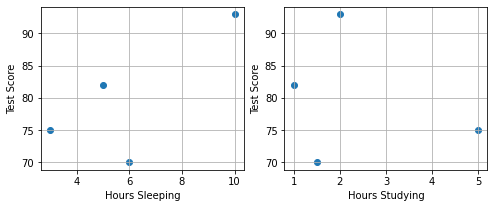

In [5]:
#Plot projections of our new data:
fig = figure(0,(8,3))

subplot(1,2,1)
scatter(X[:,0], y)
grid(1)
xlabel('Hours Sleeping')
ylabel('Test Score')

subplot(1,2,2)
scatter(X[:,1], y)
grid(1)
xlabel('Hours Studying')
ylabel('Test Score')

In [6]:
#Normalize
X = X/np.amax(X, axis=0)
y = y/100 #Max test score is 100

In [7]:
#Train network with new data:
T = trainer(NN)
T.train(X,y)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 141
         Function evaluations: 158
         Gradient evaluations: 158


Text(0, 0.5, 'Cost')

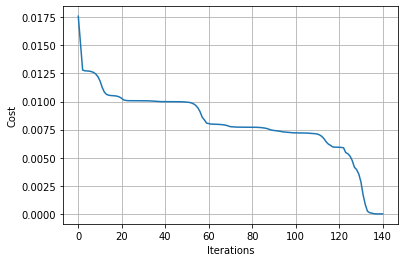

In [8]:
#Plot cost during training:
plot(T.J)
grid(1)
xlabel('Iterations')
ylabel('Cost')

In [9]:
#Test network for various combinations of sleep/study:
hoursSleep = linspace(0, 10, 100)
hoursStudy = linspace(0, 5, 100)

#Normalize data (same way training data way normalized)
hoursSleepNorm = hoursSleep/10.
hoursStudyNorm = hoursStudy/5.

#Create 2-d versions of input for plotting
a, b  = meshgrid(hoursSleepNorm, hoursStudyNorm)

#Join into a single input matrix:
allInputs = np.zeros((a.size, 2))
allInputs[:, 0] = a.ravel()
allInputs[:, 1] = b.ravel()

In [10]:
print(allInputs)

[[0.         0.        ]
 [0.01010101 0.        ]
 [0.02020202 0.        ]
 ...
 [0.97979798 1.        ]
 [0.98989899 1.        ]
 [1.         1.        ]]


In [11]:
allOutputs = NN.forward(allInputs)

Text(0, 0.5, 'Hours Study')

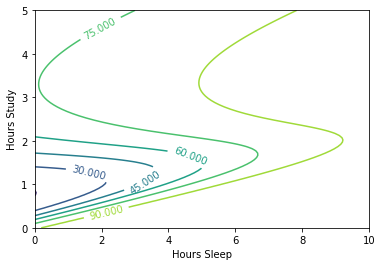

In [12]:
#Contour Plot:
yy = np.dot(hoursStudy.reshape(100,1), np.ones((1,100)))
xx = np.dot(hoursSleep.reshape(100,1), np.ones((1,100))).T

CS = contour(xx,yy,100*allOutputs.reshape(100, 100))
clabel(CS, inline=1, fontsize=10)
xlabel('Hours Sleep')
ylabel('Hours Study')

In [13]:
X1 = np.array(([0.1,0.12]))
NN.forward(X1)

array([0.32005724])

Text(0.5, 0, 'Test Score')

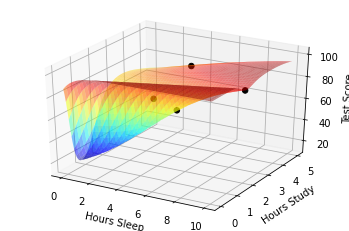

In [14]:
#3D plot:
#Uncomment to plot out-of-notebook (you'll be able to rotate)
#%matplotlib qt

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

#Scatter training examples:
ax.scatter(10*X[:,0], 5*X[:,1], 100*y, c='k', alpha = 1, s=30)


surf = ax.plot_surface(xx, yy, 100*allOutputs.reshape(100, 100), \
                       cmap=cm.jet, alpha = 0.5)


ax.set_xlabel('Hours Sleep')
ax.set_ylabel('Hours Study')
ax.set_zlabel('Test Score')

So it appears our model is overfitting, but how do we know for sure? A widely accepted method is to split our data into 2 portions: training and testing. We won’t touch our testing data while training the model, and only use it to see how we’re doing – our testing data is a simulation of the real world. We can plot the error on our training and testing sets as we train our model and identify the exact point at which overfitting begins. We can also plot testing and training error as a function of model complexity a see similar behavior. 

In [15]:
#Training Data:
trainX = np.array(([3,5], [5,1], [10,2], [6,1.5]), dtype=float)
trainY = np.array(([75], [82], [93], [70]), dtype=float)

#Testing Data:
testX = np.array(([4, 5.5], [4.5,1], [9,2.5], [6, 2]), dtype=float)
testY = np.array(([70], [89], [85], [75]), dtype=float)

#Normalize:
trainX = trainX/np.amax(trainX, axis=0)
trainY = trainY/100 #Max test score is 100

#Normalize by max of training data:
testX = testX/np.amax(trainX, axis=0)
testY = testY/100 #Max test score is 100

In [16]:
##Need to modify trainer class a bit to check testing error during training:
class trainer(object):
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))
        self.testJ.append(self.N.costFunction(self.testX, self.testY))
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        
        return cost, grad
        
    def train(self, trainX, trainY, testX, testY):
        #Make an internal variable for the callback function:
        self.X = trainX
        self.y = trainY
        
        self.testX = testX
        self.testY = testY

        #Make empty list to store training costs:
        self.J = []
        self.testJ = []
        
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(trainX, trainY), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res


In [17]:
#Train network with new data:
NN = Neural_Network()

T = trainer(NN)
T.train(trainX, trainY, testX, testY)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 160
         Function evaluations: 175
         Gradient evaluations: 175


Text(0, 0.5, 'Cost')

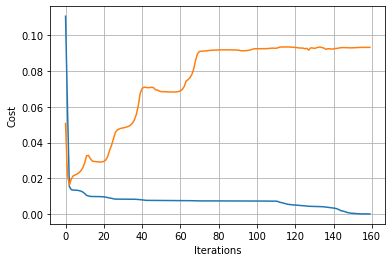

In [18]:
#Plot cost during training:
plot(T.J)
plot(T.testJ)
grid(1)
xlabel('Iterations')
ylabel('Cost')

So now that we know overfitting is a problem, but how do we fix it? One way is to throw more data at the problem. A simple rule of thumb as presented by Yaser Abu-Mostaf is his excellent machine learning course available from Caltech, is that you should have at least 10 times as many examples as the degrees for freedom in your model. For us, since we have 9 weights that can change, we would need 90 observations, which we certainly don’t have.

Link to course: https://work.caltech.edu/telecourse.html

Another popular and effective way to mitigate overfitting is to use a technique called regularization. One way to implement regularization is to add a term to our cost function that penalizes overly complex models. A simple, but effective way to do this is to add together the square of our weights to our cost function, this way, models with larger magnitudes of weights, cost more. We’ll need to normalize the other part of our cost function to ensure that our ratio of the two error terms does not change with respect to the number of examples. We’ll introduce a regularization hyper parameter, lambda, that will allow us to tune the relative cost – higher values of lambda will impose bigger penalties for high model complexity.

In [19]:
#Regularization Parameter:
Lambda = 0.0001 

In [20]:
#Need to make changes to costFunction and costFunctionPrim:
def costFunction(self, X, y):
    #Compute cost for given X,y, use weights already stored in class.
    self.yHat = self.forward(X)
    #We don't want cost to increase with the number of examples, so normalize by dividing the error term by number of examples(X.shape[0])
    J = 0.5*sum((y-self.yHat)**2)/X.shape[0] + (self.Lambda/2)*(sum(self.W1**2)+sum(self.W2**2))
    return J

def costFunctionPrime(self, X, y):
    #Compute derivative with respect to W and W2 for a given X and y:
    self.yHat = self.forward(X)

    delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
    #Add gradient of regularization term:
    dJdW2 = np.dot(self.a2.T, delta3)/X.shape[0] + self.Lambda*self.W2

    delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
    #Add gradient of regularization term:
    dJdW1 = np.dot(X.T, delta2)/X.shape[0] + self.Lambda*self.W1

    return dJdW1, dJdW2

In [21]:
#New complete class, with changes:
class Neural_Network(object):
    def __init__(self, Lambda=0):        
        #Define Hyperparameters
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 3
        
        #Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        
        #Regularization Parameter:
        self.Lambda = Lambda
        
    def forward(self, X):
        #Propogate inputs though network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)/X.shape[0] + (self.Lambda/2)*(np.sum(self.W1**2)+np.sum(self.W2**2))
        return J
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        #Add gradient of regularization term:
        dJdW2 = np.dot(self.a2.T, delta3)/X.shape[0] + self.Lambda*self.W2
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        #Add gradient of regularization term:
        dJdW1 = np.dot(X.T, delta2)/X.shape[0] + self.Lambda*self.W1
        
        return dJdW1, dJdW2
    
    #Helper functions for interacting with other methods/classes
    def getParams(self):
        #Get W1 and W2 Rolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single parameter vector:
        W1_start = 0
        W1_end = self.hiddenLayerSize*self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], \
                             (self.inputLayerSize, self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], \
                             (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

If we train our model now, we see that the fit is still good, but our model is no longer interested in “exactly” fitting our data. Further, our training and testing errors are much closer, and we’ve successfully reduced overfitting on this dataset. To further reduce overfitting, we could increase lambda.

In [22]:
NN = Neural_Network(Lambda=0.0001)

In [23]:
#Make sure our gradients our correct after making changes:
numgrad = computeNumericalGradient(NN, X, y)
grad = NN.computeGradients(X,y)

In [24]:
#Should be less than 1e-8:
norm(grad-numgrad)/norm(grad+numgrad)

8.642019155640747e-11

In [25]:
T = trainer(NN)

In [26]:
T.train(X,y,testX,testY)

Optimization terminated successfully.
         Current function value: 0.002731
         Iterations: 59
         Function evaluations: 65
         Gradient evaluations: 65


Text(0, 0.5, 'Cost')

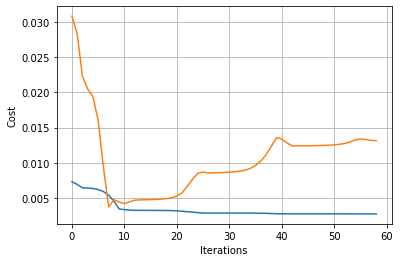

In [27]:
plot(T.J)
plot(T.testJ)
grid(1)
xlabel('Iterations')
ylabel('Cost')

Text(0, 0.5, 'Hours Study')

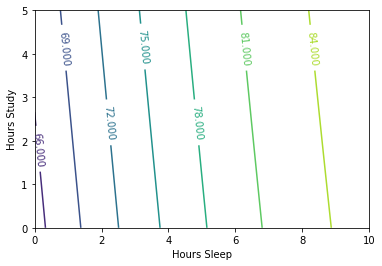

In [28]:
allOutputs = NN.forward(allInputs)

#Contour Plot:
yy = np.dot(hoursStudy.reshape(100,1), np.ones((1,100)))
xx = np.dot(hoursSleep.reshape(100,1), np.ones((1,100))).T

CS = contour(xx,yy,100*allOutputs.reshape(100, 100))
clabel(CS, inline=1, fontsize=10)
xlabel('Hours Sleep')
ylabel('Hours Study')

Text(0.5, 0, 'Test Score')

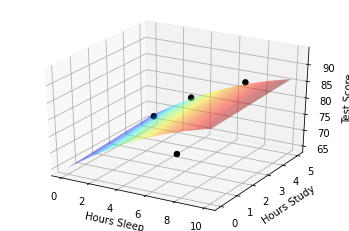

In [29]:
#3D plot:
##Uncomment to plot out-of-notebook (you'll be able to rotate)
#%matplotlib qt

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.scatter(10*X[:,0], 5*X[:,1], 100*y, c='k', alpha = 1, s=30)


surf = ax.plot_surface(xx, yy, 100*allOutputs.reshape(100, 100), \
                       cmap=cm.jet, alpha = 0.5)

ax.set_xlabel('Hours Sleep')
ax.set_ylabel('Hours Study')
ax.set_zlabel('Test Score')

And that’s it, we’ve trained and evaluated an Artificial Neural Network to predict your score on a test based on how many hours you’ve slept and studied the night before. 

<h1 align = 'center'> The End </h1>

I’ve really enjoyed making these videos, and wanted to say a big thank you to everyone who’s watched and commented. I want to point out that supporting iPython notebooks are available at welchlabs.com/blog. To be kept up to date on future videos, follow @stephencwelch on twitter, thanks!